# Certain Equivalents and Sensitivity Analysis

By: Chengyi (Jeff) Chen

In [1]:
%load_ext autotime
%load_ext nb_black
%matplotlib notebook
%config InlineBackend.figure_format = 'retina'

# Graphing
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting Design Configs
sns.set(
    font="Verdana",
    rc={
        "axes.axisbelow": False,
        "axes.edgecolor": "lightgrey",
        "axes.facecolor": "None",
        "axes.grid": True,
        "grid.color": "lightgrey",
        "axes.labelcolor": "dimgrey",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "figure.facecolor": "white",
        "lines.solid_capstyle": "round",
        "patch.edgecolor": "w",
        "patch.force_edgecolor": True,
        "text.color": "dimgrey",
        "xtick.bottom": False,
        "xtick.color": "dimgrey",
        "xtick.direction": "out",
        "xtick.top": False,
        "ytick.color": "dimgrey",
        "ytick.direction": "out",
        "ytick.left": False,
        "ytick.right": False,
        "figure.dpi": 100,
        "figure.figsize": (8, 6),
    },
)
sns.set_context(
    "notebook", rc={"font.size": 10, "axes.titlesize": 12, "axes.labelsize": 10}
)
sns.color_palette(palette="Spectral")

# General
import numpy as np
import scipy.stats as sp
import pandas as pd
from functools import partial

time: 864 ms (started: 2021-03-26 18:57:59 +08:00)


<IPython.core.display.Javascript object>

In [2]:
def ρ(γ):
    """Risk tolerance"""
    return 1 / γ

time: 294 µs (started: 2021-03-26 18:57:59 +08:00)


<IPython.core.display.Javascript object>

In [3]:
def r(γ):
    """Risk Odds"""
    return np.log(γ)

time: 280 µs (started: 2021-03-26 18:57:59 +08:00)


<IPython.core.display.Javascript object>

In [4]:
def u(x, γ: np.array = np.array([0.0]), a: float = 0.0, b: float = 1.0):
    """Assuming user satisifies the Δ property, 
    calculates the U-values using either a 
    Piecewise Linear u = a + bx if γ = 0 (Risk-Neutral) 
    else Exponential u = a + be^(-xγ) U-curve U(x)
    
    Args:
        x (np.array): Payoffs of prospects matrix, Shape = (Number of deals, Number of prospects in each deal)
        γ (np.array): Risk-aversion coefficients, Shape = (Number of different risk-aversion coefficients for sensitivity analysis), Default = 0.0 (Risk-neutral) [γ > 0: Risk-averse, γ < 0: Risk-seeking]
        a (float): Constant for U-curve
        b (float): Coefficient for payoff variable
        
    Returns:
        np.array:
            U-values, Shape = (Number of Risk Aversion Coefficients γ, Number of deals, Number of prospects in each deal)
    """
    assert (
        x.ndim == 2
    ), "Payoffs require 2 dimensions, first dim is number of deals, second is number of prospects in each deal."
    γ = np.array([γ]) if np.isscalar(γ) else np.array(γ)
    return np.array(
        [
            np.apply_along_axis(
                func1d=lambda x, γ=γ: a + b * x if γ == 0 else a + b * np.exp(-x * γ),
                axis=-1,
                arr=x,
                γ=γ_i,
            )
            for γ_i in γ
        ]
    )

time: 597 µs (started: 2021-03-26 18:57:59 +08:00)


<IPython.core.display.Javascript object>

In [5]:
def eu(u, p):
    """Assuming user satisifies the Δ property, calculates the 
    hadamard product of the u values matrix and probabilities 
    matrix (respective probabilities associated with each 
    prospect in the u matrix)
    
    Args:
        u (np.array): U-values matrix, Shape = (Number of Risk Aversion Coefficients γ, Number of deals, Number of prospects in each deal)
        p (np.array): Probabilities of each prospect matrix, Shape = (Number of Risk Aversion Coefficients γ, Number of deals, Number of prospects in each deal)
        
    Returns:
        np.array:
            E-values, Shape = (Number of Risk Aversion Coefficients γ, Number of deals) 
    """
    assert (
        u.shape == p.shape
    ), "U-values matrix must be the same shape as the probabilities matrix."

    assert (
        u.ndim == 3
    ), "Both matrices must have 3 dimensions, Shape = (Number of Risk Aversion Coefficients γ, Number of deals, Number of prospects in each deal)."

    return np.sum(u * p, axis=-1)

time: 473 µs (started: 2021-03-26 18:57:59 +08:00)


<IPython.core.display.Javascript object>

In [6]:
def u_inv(eu, γ: np.array = np.array([0.0]), a: float = 0, b: float = 1):
    """Piecewise Inverse of Linear if γ = 0 (Risk-Neutral) 
    else Inverse of Exponential U-curve Certain equivalent 
    function U^{-1}(x)
    
    Args:
        eu (np.array): E[U-Values] / Expectation over u-values, AKA E-values, Shape = (Number of Risk Aversion Coefficients γ, Number of deals)
        γ (np.array): Risk-aversion coefficients, Shape = (Number of different risk-aversion coefficients for sensitivity analysis), Default = 0.0 (Risk-neutral) [γ > 0: Risk-averse, γ < 0: Risk-seeking]
        a (float): Constant for U-curve
        b (float): Coefficient for payoff variable
        
    Returns:
        np.array:
             Certainty Equivalent values, Shape = (Number of Risk Aversion Coefficients γ, Number of deals)
    """
    γ = np.array([γ]) if np.isscalar(γ) else np.array(γ)

    for eu_i, γ_i in zip(eu, γ):
        if not np.isclose(γ_i, 0):
            assert np.alltrue(
                eu_i > 0
            ), "E[U-Values] / Expectation over u-values must be positive for γ > 0 and γ < 0 in order for inverse of Exponential U-curve to work."

    assert (
        eu.shape[0] == γ.shape[0]
    ), "E-values first dimension must be the same as γ first dimension for inverse operation."

    return np.array(
        [
            list(
                map(
                    lambda eu, γ=γ_i: (eu - a) / b if γ == 0 else -(1 / γ) * np.log(eu),
                    eu_i,
                )
            )
            for eu_i, γ_i in zip(eu, γ)
        ]
    )

time: 819 µs (started: 2021-03-26 18:58:00 +08:00)


<IPython.core.display.Javascript object>

In [7]:
def certainty_equivalent_values_calculator(
    u,
    u_inv,
    x: np.array = None,
    p: np.array = None,
    N: int = 10,
    payout_lb: float = 0.0,
    payout_ub: float = 100.0,
    γ: np.array = np.array([0.0]),
):
    """Assuming user satisifies the Δ property, calculates the Certainty Equivalent values for a given 
    payoff matrix `x` and probability matrix `p`. If both matrices
    are not provided, random matrices will be sampled to simulate
    calculations.

    Args:
        u (function): U-curve function
        u_inv (function): Inverse U-curve function
        x (np.array): Payoffs of prospects matrix, Shape = (Number of deals, Number of prospects in each deal)
        p (np.array): Probabilities of each prospect matrix, Shape = (Number of deals, Number of prospects in each deal)
        N (int): Number of prospects
        payout_lb (float): Lower Bound of Payout for simulation, Default = 0.0
        payout_ub (float): Upper Bound of Payout for simulation, Default = 100.0
        γ (np.array): Risk-aversion coefficients, Shape = (Number of different risk-aversion coefficients for sensitivity analysis), Default = 0.0 (Risk-neutral) [γ > 0: Risk-averse, γ < 0: Risk-seeking]
        
    Returns:
        np.array:
            Certainty Equivalent values, Shape = (Number of Risk Aversion Coefficients γ, Number of deals)
    """
    γ = np.array([γ]) if np.isscalar(γ) else np.array(γ)

    # Case 1: Simulator - Both x and p arent provided
    if p is None and x is None:

        # Preferential probabilities for each prospect
        p = np.random.dirichlet(np.ones(N), size=1)

        # Payouts for each prospect
        x = np.expand_dims(np.random.randint(payout_lb, payout_ub, size=N), axis=0)

    # Case 2: Simulator - Only payouts provided
    elif p is None:

        # Payouts for each prospect
        x = np.expand_dims(
            np.random.randint(payout_lb, payout_ub, size=p.shape[-1]), axis=0
        )

    # Case 3: Simulator - Only probabilities provided
    elif x is None:

        # Preferential probabilities for each prospect
        p = np.random.dirichlet(np.ones(x.shape[-1]), size=1)

    # Case 4: Calculator - Both are provided
    else:

        pass

    # Check that payoffs and probability assignments are the same shape
    assert (
        x.shape == p.shape
    ), "Payoffs `x` and Probabilities `p` must be the same shape=(Number of deals, Number of prospects in each deal)."

    # Calculates U-values Shape = (Number of Risk Aversion Coefficients γ, Number of deals, Number of prospects in each deal)
    u_values = u(x, γ=γ)

    # Reshape p to match U-values shape
    p_reshaped = np.array([p for _ in range(u_values.shape[0])])

    # Expectation of U values Shape = (Number of Risk Aversion Coefficients γ, Number of deals)
    eu_values = eu(u=u_values, p=p_reshaped)

    # Certainty equivalent value of deal
    ce_values = u_inv(eu_values, γ=γ)

    return ce_values

time: 958 µs (started: 2021-03-26 18:58:00 +08:00)


<IPython.core.display.Javascript object>

---
## 1) Simple Certain Equivalent Calculator

Build a certain equivalent calculator for a decision maker with an exponential u-curve facing a deal with 5 possible prospects with pay-offs. Build a model that allows a sensitivity analysis to the risk aversion coefficient.

<IPython.core.display.Javascript object>


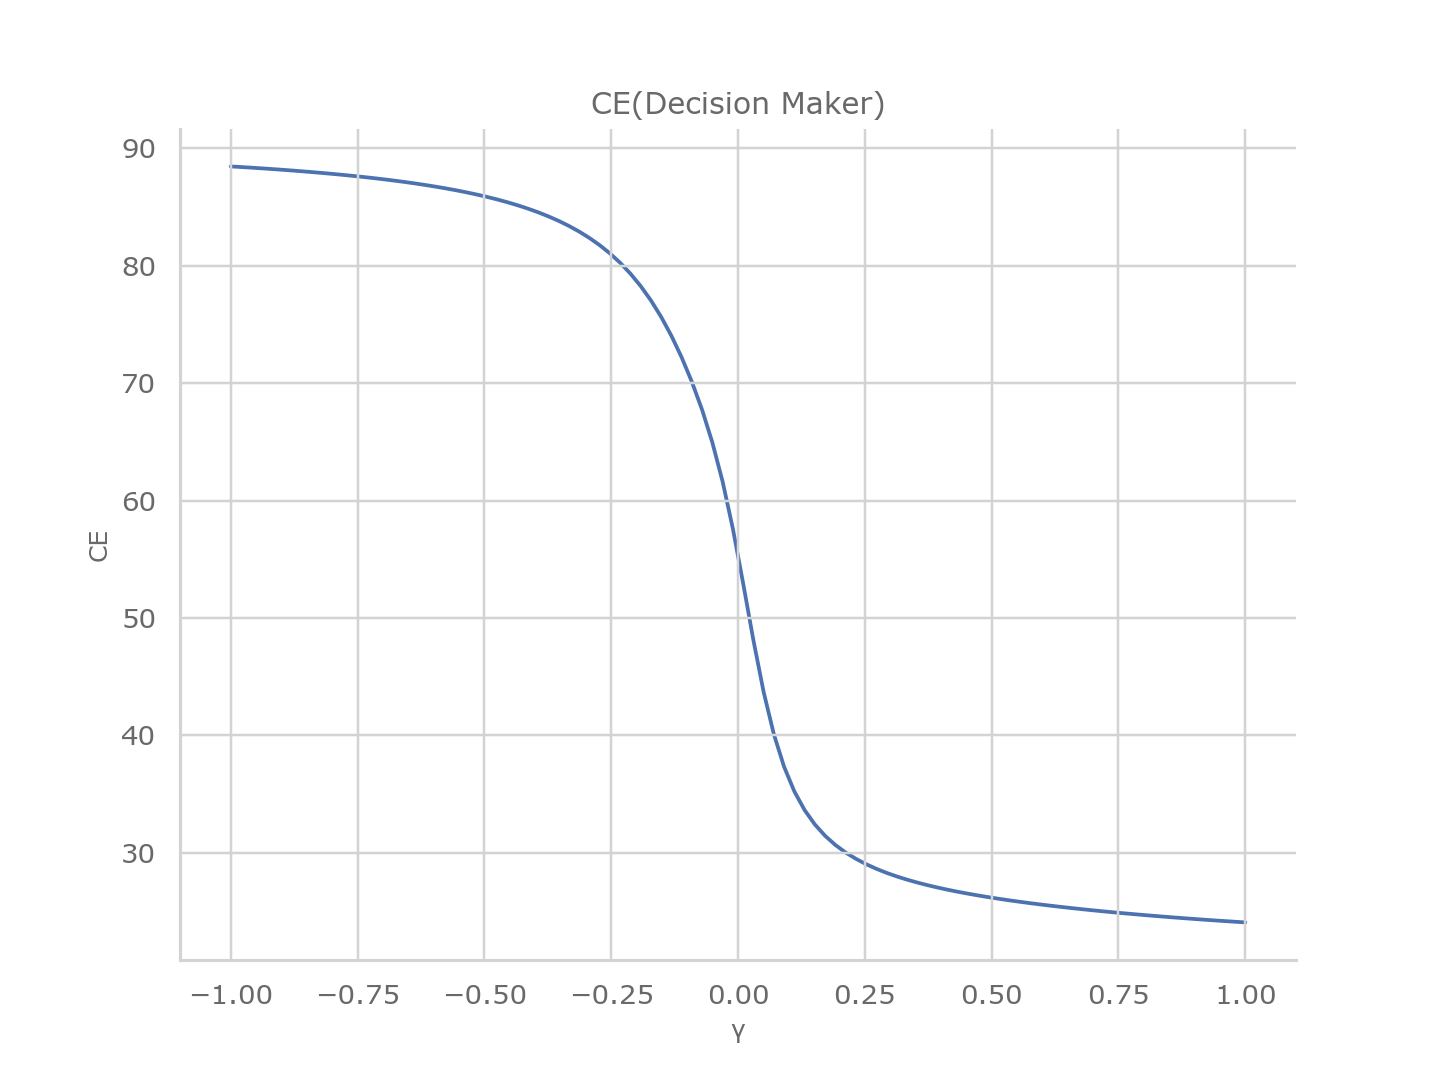

time: 35.4 ms (started: 2021-03-26 18:58:00 +08:00)


<IPython.core.display.Javascript object>

In [8]:
# Number of prospects
N = 5

# Risk-aversion coefficient
γ = np.linspace(-1, 1, num=100)

fig, ax = plt.subplots(1, 1)
ax.plot(
    γ,
    certainty_equivalent_values_calculator(
        u, u_inv, N=5, payout_lb=0, payout_ub=100, γ=γ
    ),
)
ax.set_xlabel("γ")
ax.set_ylabel("CE")
ax.set_title("CE(Decision Maker)")
plt.show()

---
## 2) 1000-degree Certain Equivalent Calculator

Build a certain equivalent calculator for a decision maker with an exponential u-curve facing a deal represented by a

- Discretized Uniform distribution on the range 1 ~ 1000

<IPython.core.display.Javascript object>


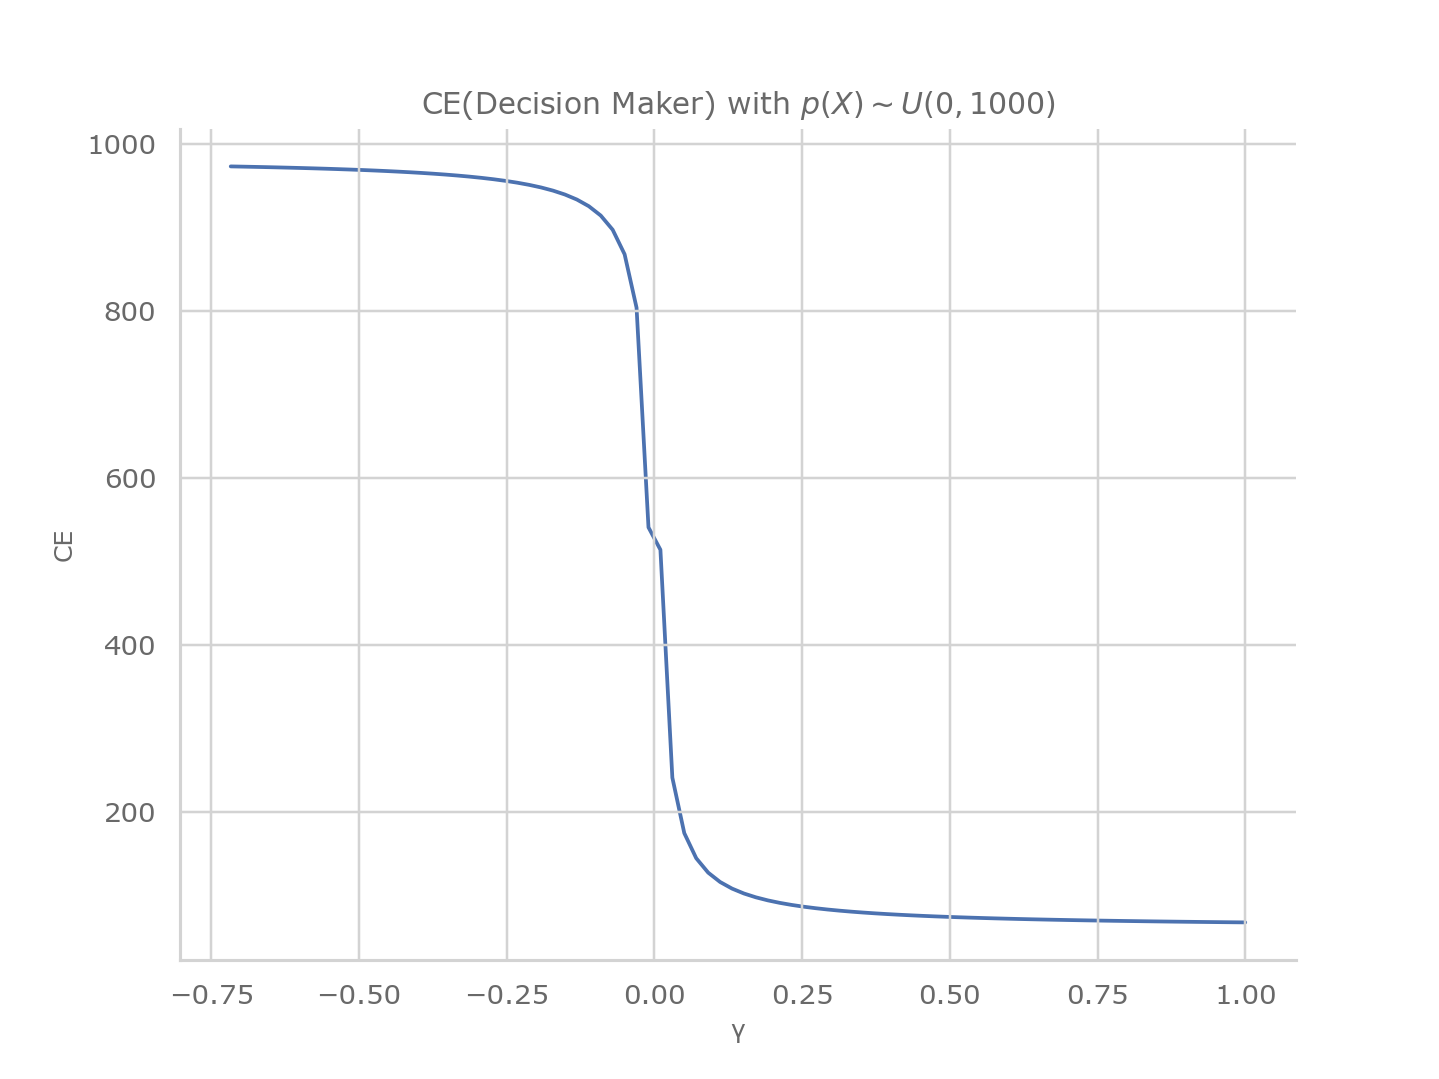

time: 34.4 ms (started: 2021-03-26 18:58:00 +08:00)


<ipython-input-4-9a6997586247>:24: RuntimeWarning: overflow encountered in exp
  func1d=lambda x, γ=γ: a + b * x if γ == 0 else a + b * np.exp(-x * γ),


<IPython.core.display.Javascript object>

In [9]:
# Number of prospects
N = 100

# Payouts for each prospect
x = np.expand_dims(
    np.array([sp.uniform.rvs(loc=0, scale=1000) for _ in range(N)]), axis=0
)

# Preferential probabilities for each prospect
p = np.array([sp.uniform.pdf(x=rv, loc=0, scale=1000) for rv in x])

# Risk-aversion coefficient
γ = np.linspace(-1, 1, num=100)


fig, ax = plt.subplots(1, 1)
ax.plot(
    γ,
    certainty_equivalent_values_calculator(
        u, u_inv, x, p, N, payout_lb=None, payout_ub=None, γ=γ
    ),
)

ax.set_xlabel("γ")
ax.set_ylabel("CE")
ax.set_title(r"CE(Decision Maker) with $p(X) \sim U(0, 1000)$")
plt.show()

- Discretized Beta distribution on the range 1 ~ 1000

<IPython.core.display.Javascript object>


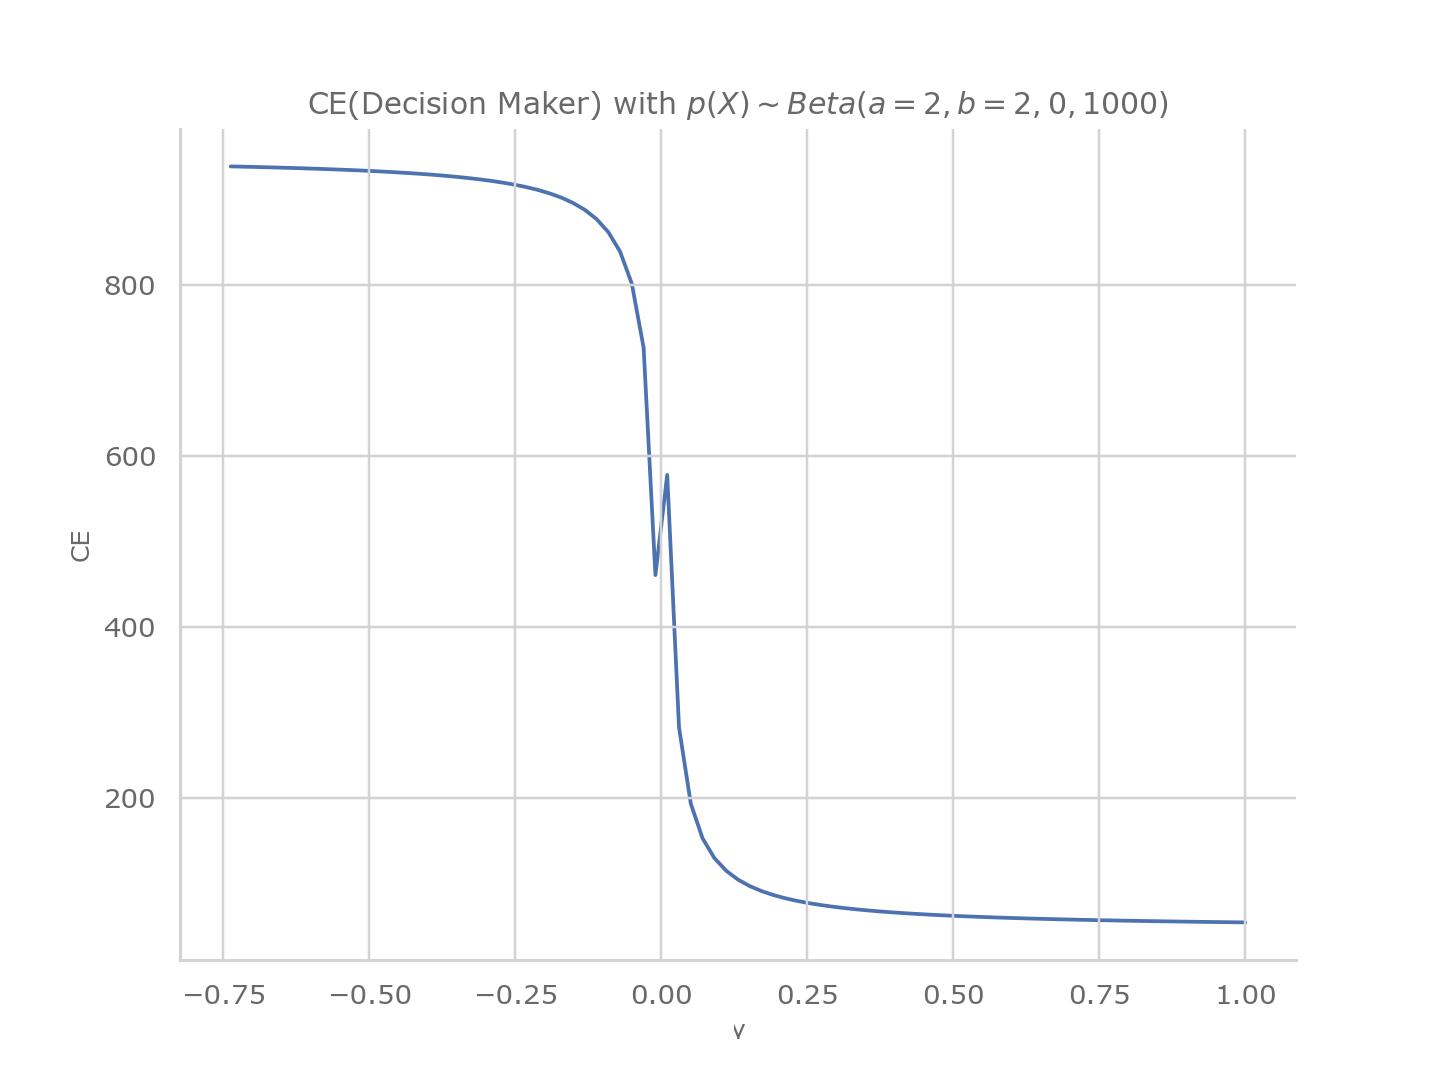

time: 40.4 ms (started: 2021-03-26 18:58:00 +08:00)


<ipython-input-4-9a6997586247>:24: RuntimeWarning: overflow encountered in exp
  func1d=lambda x, γ=γ: a + b * x if γ == 0 else a + b * np.exp(-x * γ),


<IPython.core.display.Javascript object>

In [10]:
# Number of prospects
N = 100

# Preferential probabilities for each prospect
x = np.expand_dims(
    np.array([sp.beta.rvs(a=2, b=2, loc=0, scale=1000) for _ in range(N)]), axis=0
)

# Payouts for each prospect
p = np.array([sp.beta.pdf(x=rv, a=2, b=2, loc=0, scale=1000) for rv in x])

# Risk-aversion coefficient
γ = np.linspace(-1, 1, num=100)


fig, ax = plt.subplots(1, 1)
ax.plot(
    γ,
    certainty_equivalent_values_calculator(
        u, u_inv, x, p, N, payout_lb=None, payout_ub=None, γ=γ
    ),
)

ax.set_xlabel("γ")
ax.set_ylabel("CE")
ax.set_title(r"CE(Decision Maker) with $p(X) \sim Beta(a=2, b=2, 0, 1000)$")
plt.show()

---
## 3) Heat Maps: Probability vs Severity Plots

1) Assuming a Risk-Neutral decision maker, and starting with a deal that has a 0.9 probability of losing $\$1$ Million and a 0.1 probability of a zero pay-off, find the value of $X$ in the following deals that makes you indifferent to this deal.

Let $u(x, \gamma) = e^{-x\gamma} $ and $u^{-1}(u, \gamma) = x = -\frac{1}{\gamma}\ln u$ be the $u$-value function and it's inverse.

Let $N, M$ be the number of prospects in deal $A$ and $B$ respectively.

Let $p^{(A)} \in \mathbb{R}^N: \mathbb{1}^\top  p^{(A)} = 1$ and $p^{(B)} \in \mathbb{R}^M: \mathbb{1}^\top  p^{(B)} = 1$ be the vector of probabilities of getting different prospects $a$, $b$, for deals $A$ and $B$ respectively:

\begin{align}
    u(a, \gamma)^\top  p^{(A)} &= u(b, \gamma)^\top p^{(B)} \\
    b_j &= u^{-1}\left(\frac{1}{p^{(B)}_j}\left[u(a, \gamma)^\top  p^{(A)} - \sum^M_{i, i \not= j} u(b_i, \gamma)p^{(B)}_i\right], \gamma\right) \\
\end{align}

In [11]:
b_j = lambda a, p_A, b_excl_j, p_B_excl_j, p_B_j, γ=0: u_inv(
    (np.sum(u(a, γ=γ) * p_A, axis=-1) - np.sum(u(b_excl_j, γ=γ) * p_B_excl_j, axis=-1))
    / p_B_j,
    γ=γ,
)

time: 1.25 ms (started: 2021-03-26 18:58:00 +08:00)


<IPython.core.display.Javascript object>

a) A Deal with 0.8 Probability of $X$ and 0.2 Probability of Zero

In [12]:
b_j(
    a=np.array([[-1e6, 0]]),
    p_A=np.array([[0.9, 0.1]]),
    b_excl_j=np.array([[0]]),
    p_B_excl_j=np.array([[0.2]]),
    p_B_j=np.array([[0.8]]),
)[0][0]

-1125000.0

time: 3.24 ms (started: 2021-03-26 18:58:00 +08:00)


<IPython.core.display.Javascript object>

b) A Deal with 0.7 Probability of $X$ and 0.3 Probability of Zero

In [13]:
b_j(
    a=np.array([[-1e6, 0]]),
    p_A=np.array([[0.9, 0.1]]),
    b_excl_j=np.array([[0]]),
    p_B_excl_j=np.array([[0.3]]),
    p_B_j=np.array([[0.7]]),
)[0][0]

-1285714.2857142857

time: 3.54 ms (started: 2021-03-26 18:58:00 +08:00)


<IPython.core.display.Javascript object>

c) A Deal with 0.6 Probability of $X$ and 0.4 Probability of Zero

In [14]:
b_j(
    a=np.array([[-1e6, 0]]),
    p_A=np.array([[0.9, 0.1]]),
    b_excl_j=np.array([[0]]),
    p_B_excl_j=np.array([[0.4]]),
    p_B_j=np.array([[0.6]]),
)[0][0]

-1500000.0

time: 3.91 ms (started: 2021-03-26 18:58:00 +08:00)


<IPython.core.display.Javascript object>

d) A Deal with 0.5 Probability of $X$ and 0.5 Probability of Zero

In [15]:
b_j(
    a=np.array([[-1e6, 0]]),
    p_A=np.array([[0.9, 0.1]]),
    b_excl_j=np.array([[0]]),
    p_B_excl_j=np.array([[0.5]]),
    p_B_j=np.array([[0.5]]),
)[0][0]

-1800000.0

time: 3.37 ms (started: 2021-03-26 18:58:00 +08:00)


<IPython.core.display.Javascript object>

e) A Deal with 0.4 Probability of $X$ and 0.6 Probability of Zero

In [16]:
b_j(
    a=np.array([[-1e6, 0]]),
    p_A=np.array([[0.9, 0.1]]),
    b_excl_j=np.array([[0]]),
    p_B_excl_j=np.array([[0.6]]),
    p_B_j=np.array([[0.4]]),
)[0][0]

-2250000.0

time: 2.96 ms (started: 2021-03-26 18:58:00 +08:00)


<IPython.core.display.Javascript object>

f) A Deal with 0.3 Probability of $X$ and 0.7 Probability of Zero

In [17]:
b_j(
    a=np.array([[-1e6, 0]]),
    p_A=np.array([[0.9, 0.1]]),
    b_excl_j=np.array([[0]]),
    p_B_excl_j=np.array([[0.7]]),
    p_B_j=np.array([[0.3]]),
)[0][0]

-3000000.0

time: 3.16 ms (started: 2021-03-26 18:58:00 +08:00)


<IPython.core.display.Javascript object>

g) A Deal with 0.2 Probability of $X$ and 0.8 Probability of Zero

In [18]:
b_j(
    a=np.array([[-1e6, 0]]),
    p_A=np.array([[0.9, 0.1]]),
    b_excl_j=np.array([[0]]),
    p_B_excl_j=np.array([[0.8]]),
    p_B_j=np.array([[0.2]]),
)[0][0]

-4500000.0

time: 3.17 ms (started: 2021-03-26 18:58:00 +08:00)


<IPython.core.display.Javascript object>

h) A Deal with 0.1 Probability of $X$ and 0.9 Probability of Zero

In [19]:
b_j(
    a=np.array([[-1e6, 0]]),
    p_A=np.array([[0.9, 0.1]]),
    b_excl_j=np.array([[0]]),
    p_B_excl_j=np.array([[0.9]]),
    p_B_j=np.array([[0.1]]),
)[0][0]

-9000000.0

time: 2.98 ms (started: 2021-03-26 18:58:00 +08:00)


<IPython.core.display.Javascript object>

Plot the (Probability of $X$) vs. $X$.

<IPython.core.display.Javascript object>


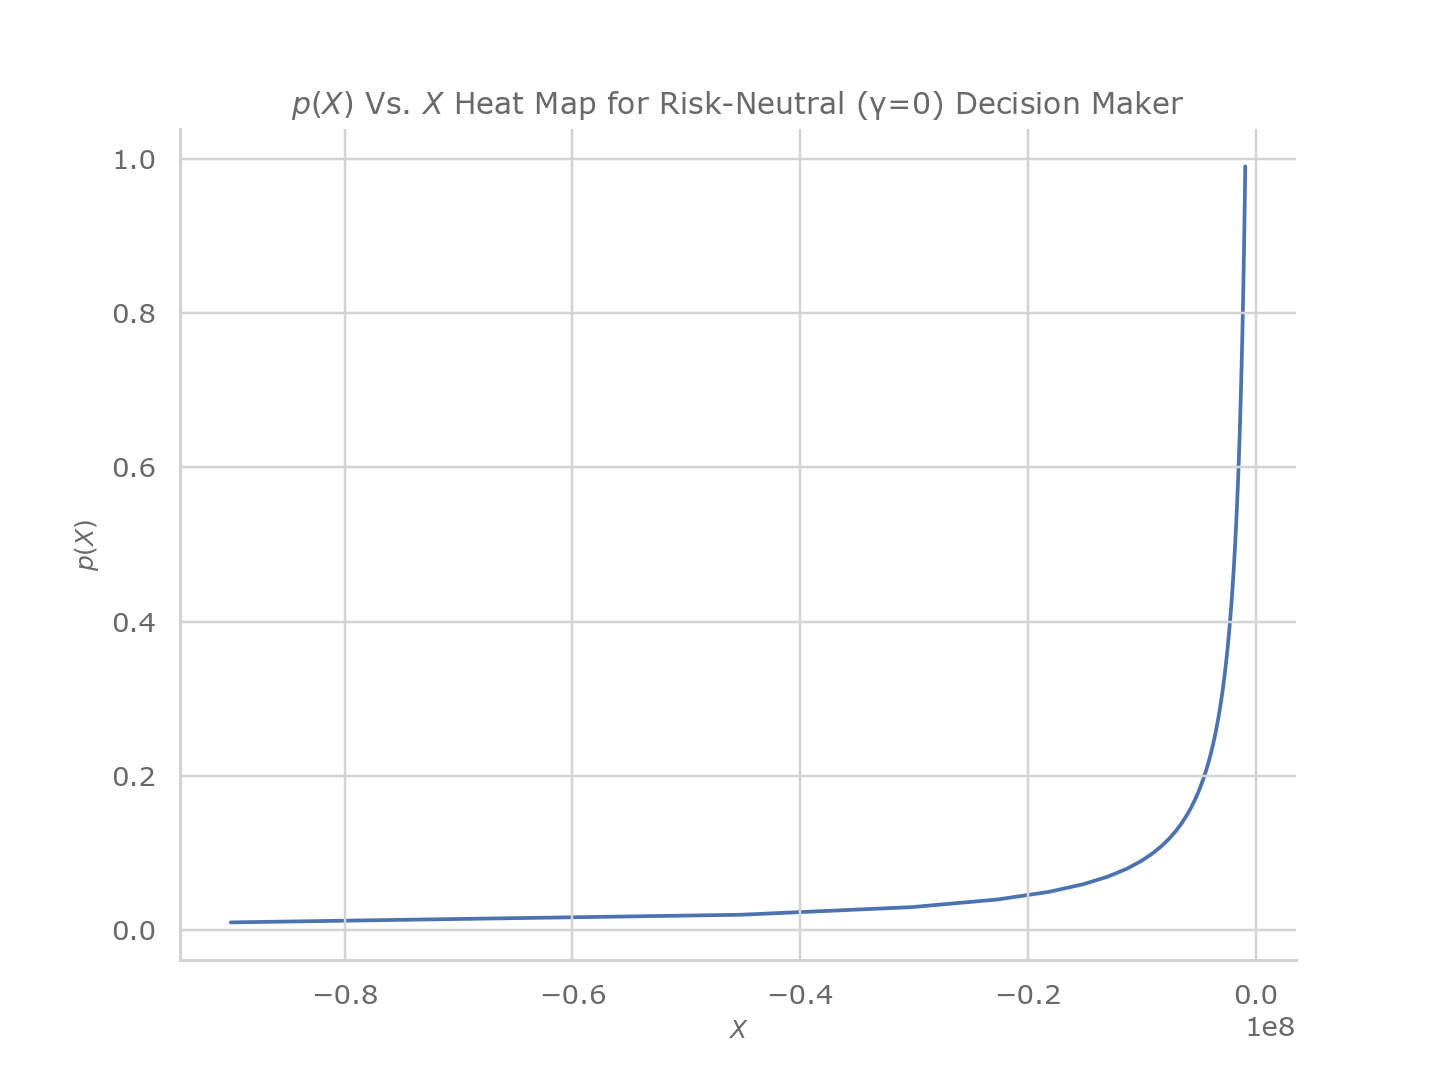

time: 55.4 ms (started: 2021-03-26 18:58:00 +08:00)


<IPython.core.display.Javascript object>

In [20]:
fig, ax = plt.subplots(1, 1)
ax.plot(
    np.array(
        [
            b_j(
                a=np.array([[-1e6, 0]]),
                p_A=np.array([[0.9, 0.1]]),
                b_excl_j=np.array([[0]]),
                p_B_excl_j=np.array([[1 - p_B_j]]),
                p_B_j=np.array([[p_B_j]]),
            )[0][0]
            for p_B_j in np.linspace(0.01, 0.99, num=100)
        ]
    ),
    np.linspace(0.01, 0.99, num=100),
    label="γ = 0",
)
ax.set_xlabel(r"$X$")
ax.set_ylabel(r"$p(X)$")
ax.set_title(r"$p(X)$ Vs. $X$ Heat Map for Risk-Neutral (γ=0) Decision Maker")
plt.show()

2) Repeat for a decision maker with a Risk Aversion Coefficient of $10^{-6}$.

<IPython.core.display.Javascript object>


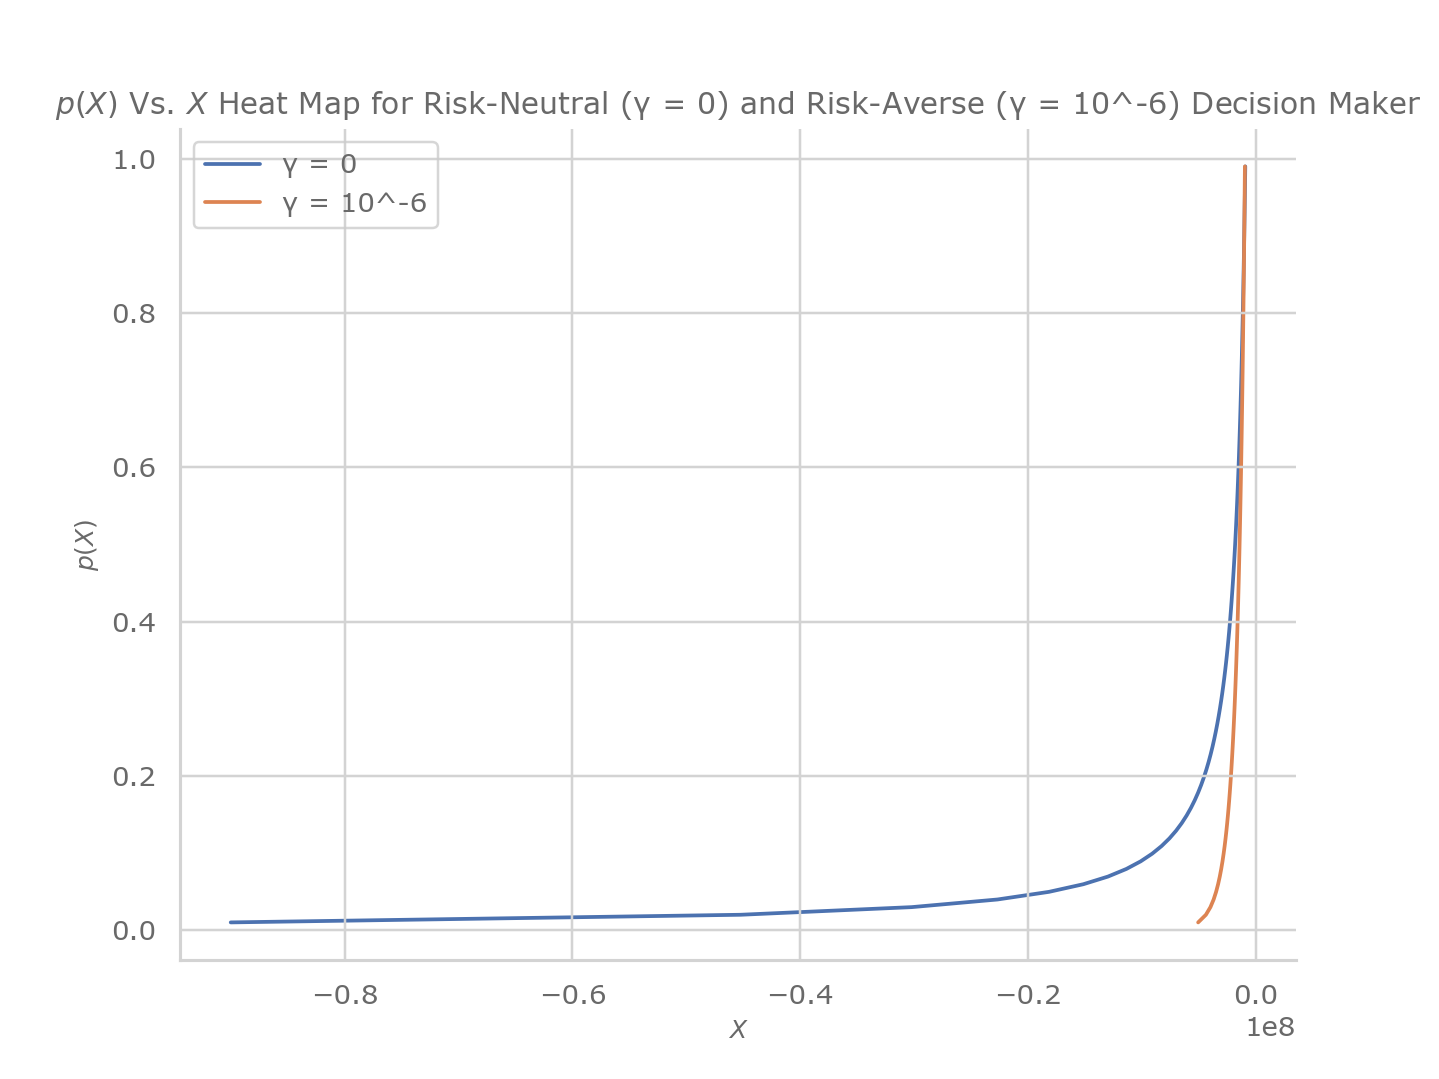

time: 86.5 ms (started: 2021-03-26 18:58:00 +08:00)


<IPython.core.display.Javascript object>

In [21]:
fig, ax = plt.subplots(1, 1)
ax.plot(
    np.array(
        [
            b_j(
                a=np.array([[-1e6, 0]]),
                p_A=np.array([[0.9, 0.1]]),
                b_excl_j=np.array([[0]]),
                p_B_excl_j=np.array([[1 - p_B_j]]),
                p_B_j=np.array([[p_B_j]]),
                γ=0,
            )[0][0]
            for p_B_j in np.linspace(0.01, 0.99, num=100)
        ]
    ),
    np.linspace(0.01, 0.99, num=100),
    label="γ = 0",
)

ax.plot(
    np.array(
        [
            b_j(
                a=np.array([[-1e6, 0]]),
                p_A=np.array([[0.9, 0.1]]),
                b_excl_j=np.array([[0]]),
                p_B_excl_j=np.array([[1 - p_B_j]]),
                p_B_j=np.array([[p_B_j]]),
                γ=1e-06,
            )[0]
            for p_B_j in np.linspace(0.01, 0.99, num=100)
        ]
    ),
    np.linspace(0.01, 0.99, num=100),
    label="γ = 10^-6",
)

ax.set_xlabel(r"$X$")
ax.set_ylabel(r"$p(X)$")
ax.set_title(
    r"$p(X)$ Vs. $X$ Heat Map for Risk-Neutral (γ = 0) and Risk-Averse (γ = 10^-6) Decision Maker"
)
plt.legend()
plt.show()

---
## 4) Risk-Sensitivity Profile

Plot the Risk Sensitivity profile for the following two deals. 

The Risk-Sensitivity profile is a plot of the certain equivalent of a deal vs, the risk aversion coefficient, $\gamma$. Draw the plot from $\gamma = −1$ to $\gamma = +1$

<img src="./images/lab_assignment_q4.png" width="60%"/>

<IPython.core.display.Javascript object>


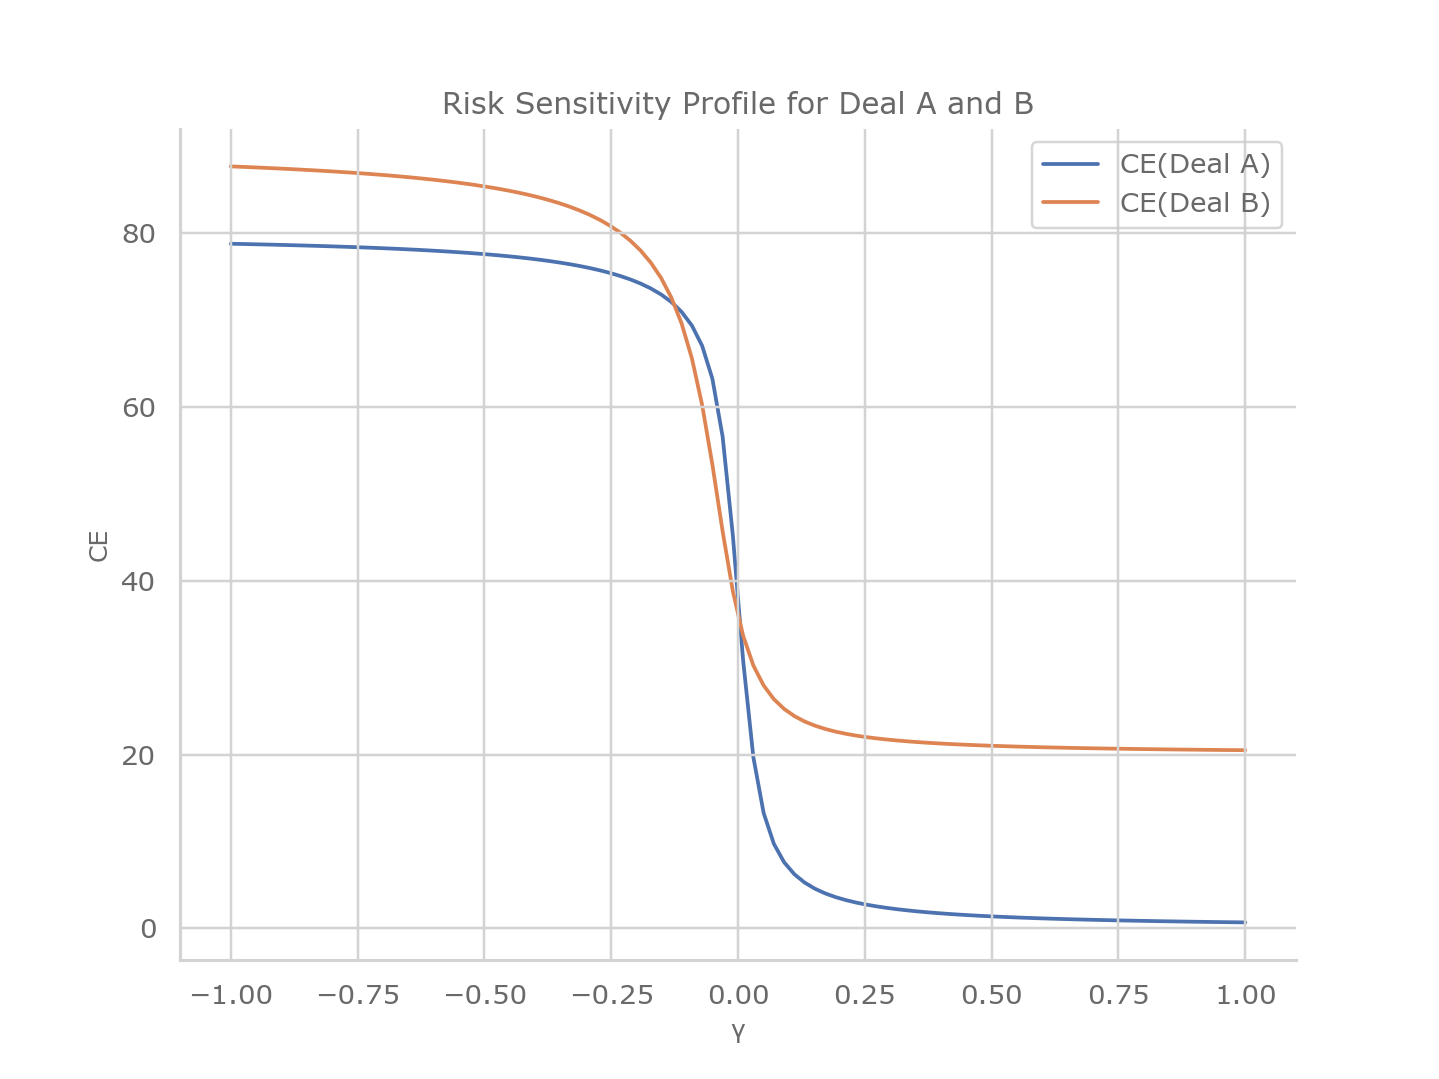

time: 43 ms (started: 2021-03-26 18:58:00 +08:00)


<IPython.core.display.Javascript object>

In [22]:
# Risk-aversion coefficient
γ = np.linspace(-1, 1, num=100)


fig, ax = plt.subplots(1, 1)
ax.plot(
    γ,
    certainty_equivalent_values_calculator(
        u,
        u_inv,
        np.array([[80, 70, 0]]),
        np.array([[0.3, 0.2, 0.5]]),
        N,
        payout_lb=None,
        payout_ub=None,
        γ=γ,
    ),
    label=r"CE(Deal A)",
)

ax.plot(
    γ,
    certainty_equivalent_values_calculator(
        u,
        u_inv,
        np.array([[90, 50, 20]]),
        np.array([[0.1, 0.3, 0.6]]),
        N,
        payout_lb=None,
        payout_ub=None,
        γ=γ,
    ),
    label=r"CE(Deal B)",
)
ax.set_xlabel("γ")
ax.set_ylabel("CE")
ax.set_title("Risk Sensitivity Profile for Deal A and B")
plt.legend()
plt.show()

---
## 5) Large Monetary Prospects Using an Exponential U-Curve
In the deal below, assume $p = 0.5$ and a decision maker with an exponential u-curve and a risk-aversion coefficient $\gamma = 0.001$. I.e. the equation for the u-curve is 

\begin{align}
    u(x) &= a + b{e}^{-\gamma x} ,b \not= 0. \\
\end{align}

Plot the certain equivalent of the deal vs. $X$ for the range where $X=\$0$ to $X=\$10,000$ in increments of ${\$500}$.

Explain and interpret the results.

<img src="./images/lab_assignment_q5.png" width="60%"/>

<IPython.core.display.Javascript object>


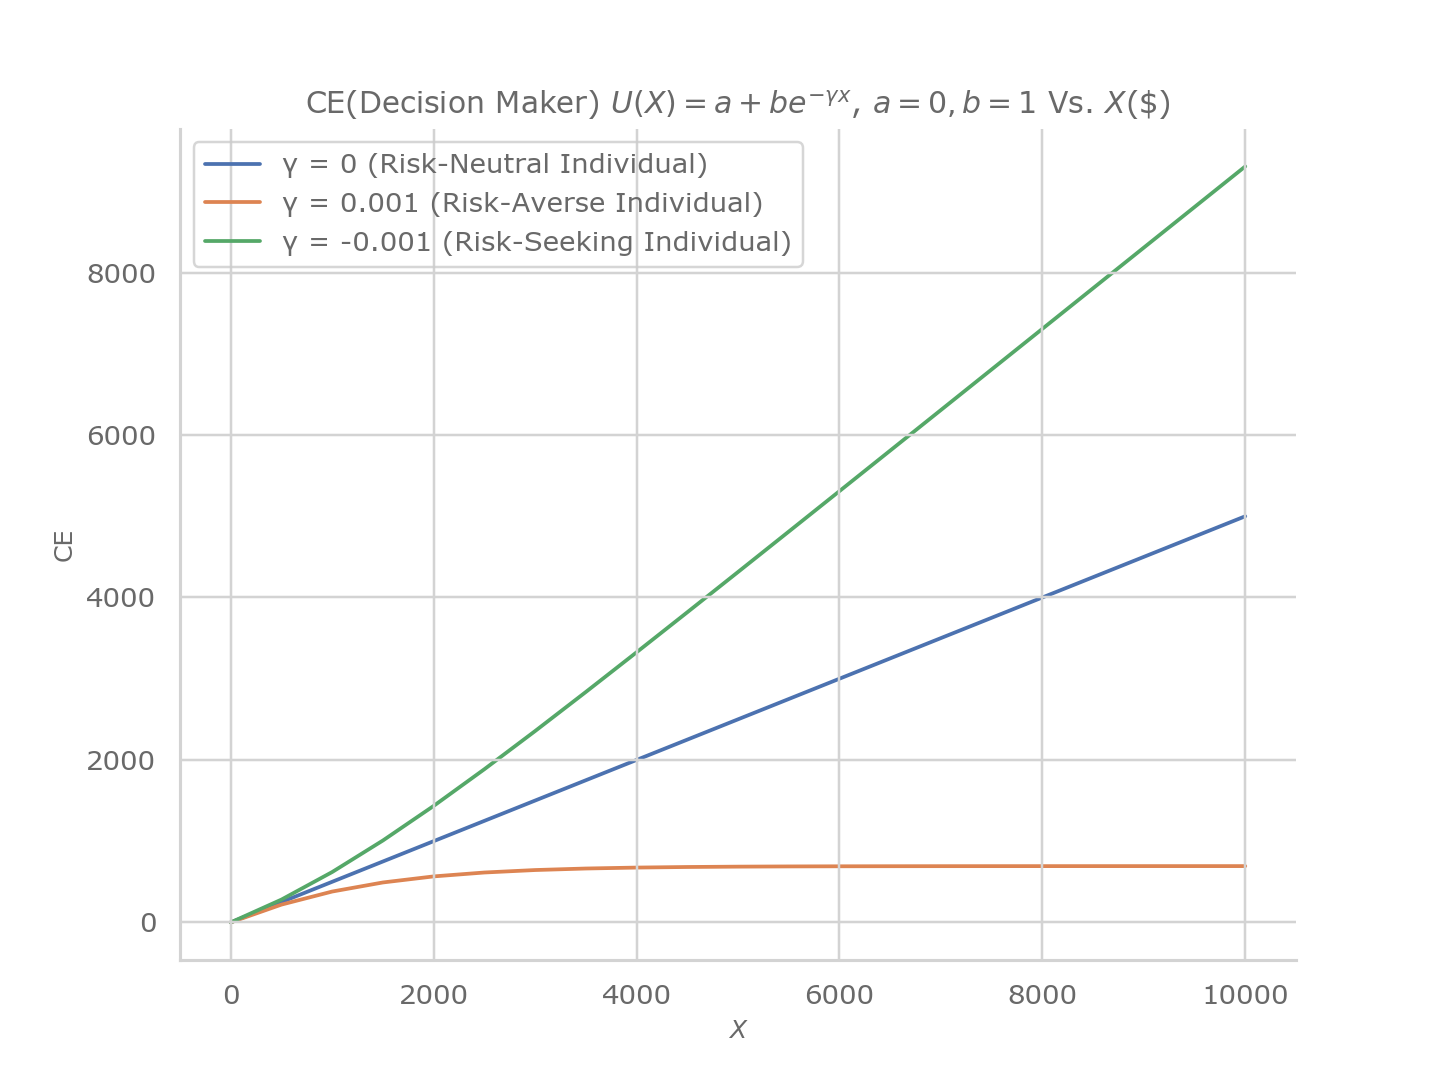

time: 33.3 ms (started: 2021-03-26 18:58:00 +08:00)


<IPython.core.display.Javascript object>

In [23]:
# Preferential probabilities for each prospect
x = np.array(
    list(zip(np.arange(0, 1e4 + 1, 500), np.zeros(len(np.arange(0, 1e4 + 1, 500)))))
)

# Payouts for each prospect
p = np.array([[0.5, 0.5] for _ in x])

# Risk-aversion coefficient
γ = np.array([0, 0.001, -0.001])

fig, ax = plt.subplots(1, 1)

ax.plot(
    x[:, 0],
    certainty_equivalent_values_calculator(
        u, u_inv, x, p, N=None, payout_lb=None, payout_ub=None, γ=γ
    )[0],
    label="γ = 0 (Risk-Neutral Individual)",
)

ax.plot(
    x[:, 0],
    certainty_equivalent_values_calculator(
        u, u_inv, x, p, N=None, payout_lb=None, payout_ub=None, γ=γ
    )[1],
    label="γ = 0.001 (Risk-Averse Individual)",
)

ax.plot(
    x[:, 0],
    certainty_equivalent_values_calculator(
        u, u_inv, x, p, N=None, payout_lb=None, payout_ub=None, γ=γ
    )[2],
    label="γ = -0.001 (Risk-Seeking Individual)",
)

ax.set_xlabel(r"$X$")
ax.set_ylabel("CE")
ax.set_title(
    r"CE(Decision Maker) $U(X) = a + be^{-\gamma x}$, $a = 0, b = 1$ Vs. $X$(\$)"
)
plt.legend()
plt.show()

We notice that the risk-averse individual ($\gamma = 0.001 > 0$)'s certainty equivalent value for all gambles are lower than the risk-neutral individual ($\gamma = 0$), and much lower than the risk-seeking individual ($\gamma = -0.001 < 0$). For example, when presented with a deal to win $\$4,000$ or nothing with equal probability, the risk-neutral individual is indifferent to playing the deal or simply getting the traditional expected value of $\mathbb{E}\left[X\right] = \$2,000.00$. The risk-averse individual will be indifferent to that deal or getting $\$675.00$ while the risk-seeking individual will be indifferent to that deal or getting $\$3,325.00$.

---
## 6) EXTRA CREDIT: Sensitivity to Value of Clairvoyance

In the party problem, the following table represents the probabilities, prospects, and $u$-values for Kim, Mary, and Jane.

<img src="./images/lab_assignment_q6.png" width="60%"/>

a) Kim’s risk Odd for $\$50$ are $r_{50} = 2 :1$. What is her risk tolerance?

Assuming that Kim satisfies the $\Delta$ property,

\begin{align}
    r_{50} &= \frac{2}{1} \\
    r &= {\left(\frac{2}{1}\right)}^{\frac{1}{50}} \\
    \text{Risk Tolerance } \rho &= \frac{1}{\ln (r)} \\
    &= \frac{50}{\ln (2)} \\
\end{align}

Also, we can find her risk tolerance by comparing the forms of the exponential $U$-curves:

\begin{align}
    a + br^{-x} &= a + be^{-\frac{x}{\rho}} \\
    \frac{4}{3} - \frac{4}{3} {\left(\frac{1}{2}\right)}^{\frac{x}{50}} &= \frac{4}{3} - \frac{4}{3}e^{-\frac{x}{\rho}} \\
    {2}^{-\frac{x}{50}} &= e^{-\frac{x}{\rho}} \\
    \frac{x}{50}\ln (2) &= \frac{x}{\rho} \\
    \rho &= \frac{50}{\ln (2)} \\
\end{align}

b) Build a spreadsheet to calculate the Value of Clairvoyance for each person.

Assuming a person satisfies the $\Delta$ property,

\begin{align}
    \text{Value of Clairvoyance} &= \text{Value of Free Clairvoyance} - \text{Value of No Clairvoyance} \\   
\end{align}

In [24]:
def value_of_clairvoyance(u, u_inv, x, p):
    """Calculates the Value of Clairvoyance
    = Value of Free Clairvoyance - Value of No Clairvoyance
    AKA How much more value we get when we have access
    to an oracle that can tell us the actual outcome of a
    random event.
    
    Args:
        u (function): U-curve function
        u_inv (function): Inverse U-curve function
        x (np.array): Payoffs of prospects matrix, Shape = (Number of deals, Number of prospects in each deal)
        p (np.array): Probabilities of each prospect matrix, Shape = (Number of deals, Number of prospects in each deal)
        
    Returns:
        float:
            Value of the Clairvoyance
    """

    # Check that payoffs and probability assignments are the same shape
    assert (
        x.shape == p.shape
    ), "Payoffs `x` and Probabilities `p` must be the same shape=(Number of deals, Number of prospects in each deal)."

    # Value of Free Clairvoyance
    vfc = certainty_equivalent_values_calculator(
        u=u,
        u_inv=u_inv,
        x=np.array([x.max(axis=0)]),
        p=np.array([p[np.argmax(x, axis=0), np.array(range(x.shape[1]))]]),
        γ=np.array([u.keywords["γ"]]),
    )[0][0]

    # Value of No Clairvoyance
    vnc = np.max(
        certainty_equivalent_values_calculator(
            u=u, u_inv=u_inv, x=x, p=p, γ=np.array([u.keywords["γ"]]),
        )
    )

    # Value of Clairvoyance
    return np.round(vfc - vnc, 2)

time: 2 ms (started: 2021-03-26 18:58:00 +08:00)


<IPython.core.display.Javascript object>

Kim's Value of Clairvoyance

In [25]:
# Probabilities of Sun and Rain
p = np.array([[0.4, 0.6]])

# Prospect Valuation
x_kim = pd.DataFrame(
    np.array([[100, 90, 40], [0, 20, 50]]),
    index=["Sun", "Rain"],
    columns=["Outdoors", "Porch", "Indoors"],
)

value_of_clairvoyance(
    u=partial(u, γ=np.log(2) / 50, a=4 / 3, b=-4 / 3),
    u_inv=partial(u_inv, γ=np.log(2) / 50, a=4 / 3, b=-4 / 3),
    x=x_kim.T.values,
    p=np.repeat(p, repeats=x_kim.T.shape[0], axis=0),
)

-50.0

time: 6.39 ms (started: 2021-03-26 18:58:00 +08:00)


<IPython.core.display.Javascript object>

Jane's Value of Clairvoyance

In [26]:
# Probabilities of Sun and Rain
p = np.array([[0.4, 0.6]])

# Prospect Valuation
x_jane = pd.DataFrame(
    np.array([[100, 90, 40], [0, 20, 50]]),
    index=["Sun", "Rain"],
    columns=["Outdoors", "Porch", "Indoors"],
)

value_of_clairvoyance(
    u=partial(u, γ=0, a=0, b=1),
    u_inv=partial(u_inv, γ=0, a=0, b=1),
    x=x_jane.T.values,
    p=np.repeat(p, repeats=x_jane.T.shape[0], axis=0),
)

22.0

time: 7.24 ms (started: 2021-03-26 18:58:00 +08:00)


<IPython.core.display.Javascript object>

Mary's Value of Clairvoyance

In [27]:
# Probabilities of Sun and Rain
p = np.array([[0.4, 0.6]])

# Prospect Valuation
x_mary = pd.DataFrame(
    np.array([[100, 95, 57], [0, 32, 67]]),
    index=["Sun", "Rain"],
    columns=["Outdoors", "Porch", "Indoors"],
)

value_of_clairvoyance(
    u=partial(u, γ=0, a=0, b=1),
    u_inv=partial(u_inv, γ=0, a=0, b=1),
    x=x_mary.T.values,
    p=np.repeat(p, repeats=x_mary.T.shape[0], axis=0),
)

17.2

time: 8.09 ms (started: 2021-03-26 18:58:00 +08:00)


<IPython.core.display.Javascript object>

c) Conduct a sensitivity analysis of the Value of Clairvoyance to the probability of Sun for each person and plot the three-curves on one graph.

<IPython.core.display.Javascript object>


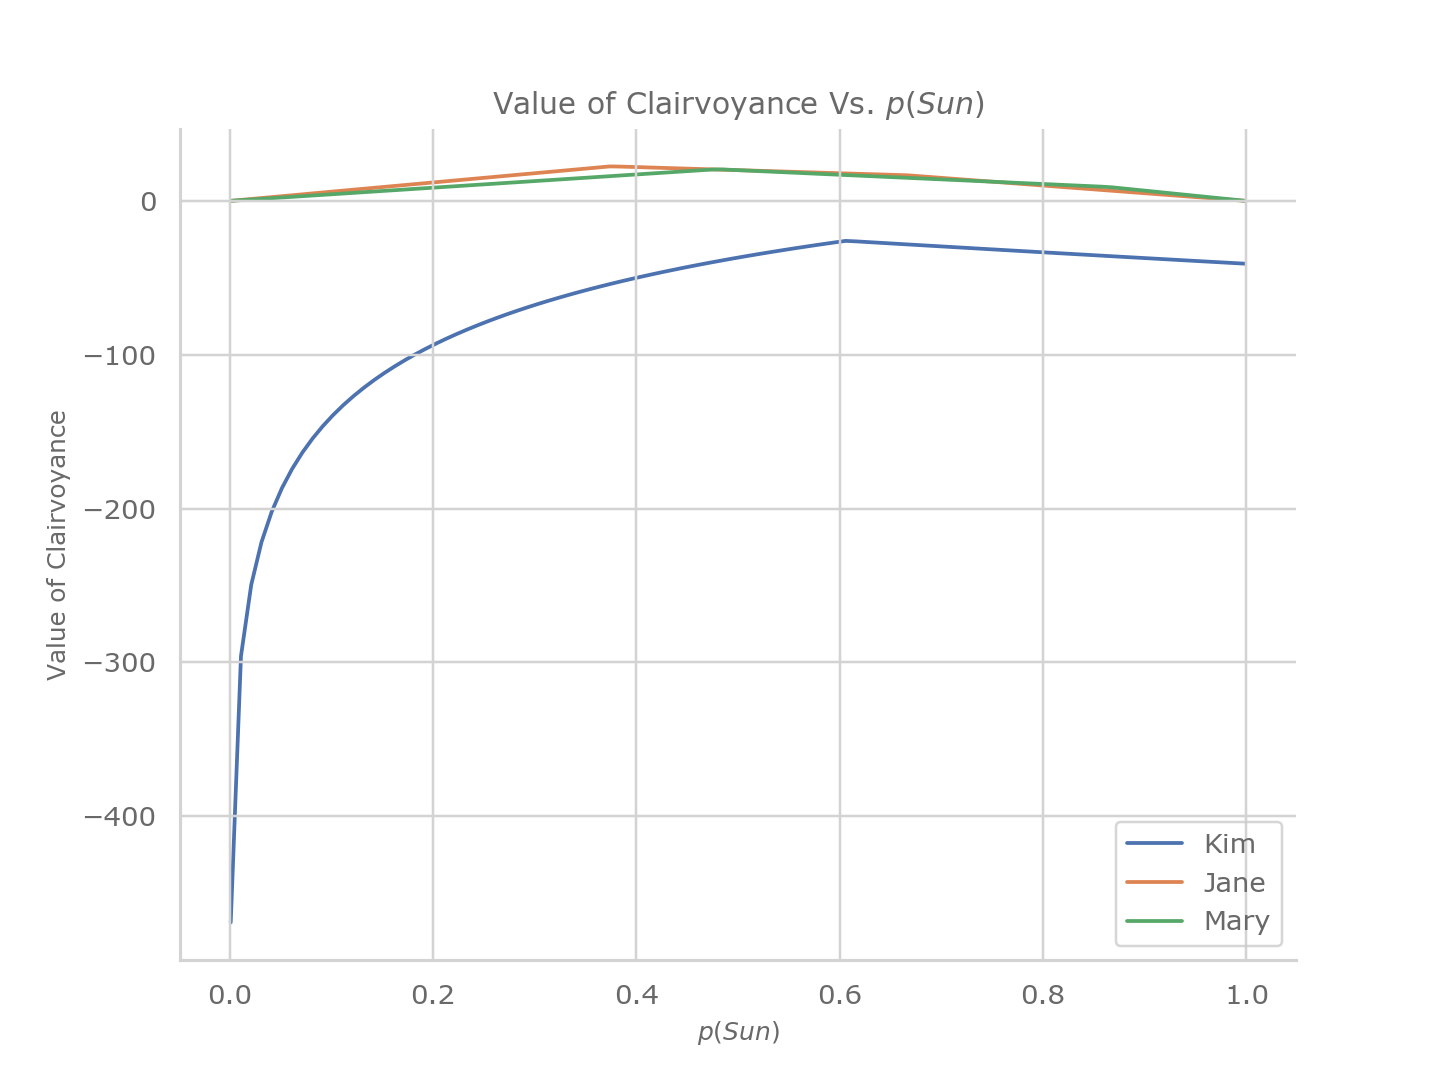

time: 188 ms (started: 2021-03-26 18:58:00 +08:00)


<IPython.core.display.Javascript object>

In [28]:
# Range of P(Sun) values to perform sensitivity analysis of VOC over
p_sun_values = np.linspace(0.001, 0.999, num=100)

# VOC values for each P(Sun) value
kim_voc_values, jane_voc_values, mary_voc_values = [
    [
        value_of_clairvoyance(
            u=u,
            u_inv=u_inv,
            x=x,
            p=np.repeat(np.array([[p_sun, 1 - p_sun]]), repeats=x.shape[0], axis=0),
        )
        for p_sun in p_sun_values
    ]
    for u, u_inv, x in [
        [
            partial(u, γ=np.log(2) / 50, a=4 / 3, b=-4 / 3),
            partial(u_inv, γ=np.log(2) / 50, a=4 / 3, b=-4 / 3),
            x_kim.T.values,
        ],
        [partial(u, γ=0, a=0, b=1), partial(u_inv, γ=0, a=0, b=1), x_jane.T.values],
        [partial(u, γ=0, a=0, b=1), partial(u_inv, γ=0, a=0, b=1), x_mary.T.values],
    ]
]

fig, ax = plt.subplots(1, 1)

ax.plot(
    p_sun_values, kim_voc_values, label="Kim",
)

ax.plot(
    p_sun_values, jane_voc_values, label="Jane",
)

ax.plot(
    p_sun_values, mary_voc_values, label="Mary",
)

ax.set_xlabel(r"$p(Sun)$")
ax.set_ylabel("Value of Clairvoyance")
ax.set_title(r"Value of Clairvoyance Vs. $p(Sun)$")
plt.legend()
plt.show()

d) Conduct a sensitivity analysis of VOC to both probability of Sun and the risk aversion coefficient for Kim.

<IPython.core.display.Javascript object>


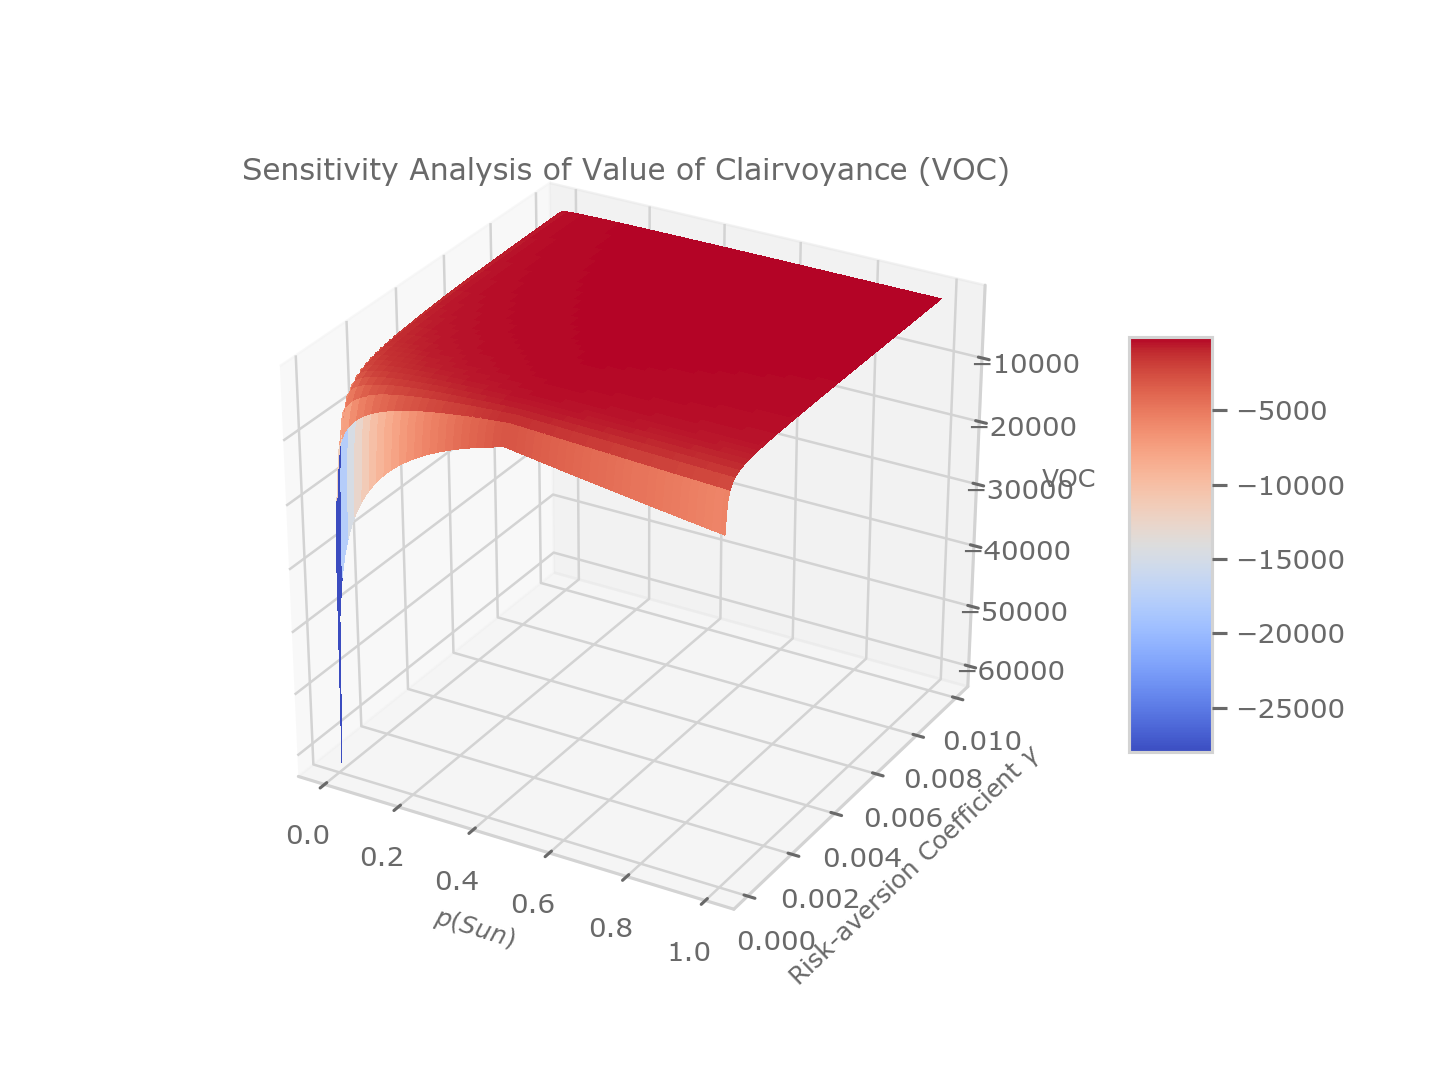

time: 8.56 s (started: 2021-03-26 18:58:01 +08:00)


<IPython.core.display.Javascript object>

In [29]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, colors
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Because EU values need to be positive for
# the inverse of an exponential to be defined,
# Kim's U-curve demands that γ values should
# be chosen such that e^{-xγ} <= 1. Hence, we wil
# only perfrom sensitivity analysis over γ > 0
γ = np.linspace(0.0001, 0.0099, num=100)
X, Y = np.meshgrid(p_sun_values, γ)
Z = np.array(
    [
        [
            value_of_clairvoyance(
                u=partial(u, γ=γ_i, a=4 / 3, b=-4 / 3),
                u_inv=partial(u_inv, γ=γ_i, a=4 / 3, b=-4 / 3),
                x=x_kim.T.values,
                p=np.repeat(
                    np.array([[p_sun, 1 - p_sun]]), repeats=x_kim.T.shape[0], axis=0
                ),
            )
            for p_sun in p_sun_values
        ]
        for γ_i in γ
    ]
)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False,)
ax.set_xlabel(r"$p(Sun)$")
ax.set_ylabel(r"Risk-aversion Coefficient $\gamma$")
ax.set_zlabel("VOC")
ax.set_title("Sensitivity Analysis of Value of Clairvoyance (VOC)")

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()